[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/kadenze-deeplearning-creative-applications/blob/master/Kadenze_Session_3.ipynb)

In [0]:
%matplotlib inline
#%pylab

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.style.use('ggplot')

In [2]:
!git clone https://github.com/JacksonIsaac/CADL.git
!mv CADL/session-3/* .

Cloning into 'CADL'...
remote: Counting objects: 2074, done.
remote: Total 2074 (delta 0), reused 0 (delta 0), pack-reused 2074
Receiving objects: 100% (2074/2074), 322.71 MiB | 28.02 MiB/s, done.
Resolving deltas: 100% (1032/1032), done.


In [0]:
from libs.utils import montage
from libs import gif
from libs.datasets import MNIST

In [4]:
ds = MNIST()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
ds.X.shape

(70000, 784)

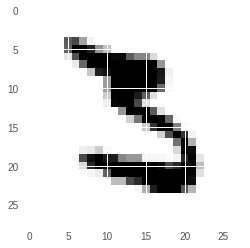

In [6]:
plt.imshow(ds.X[0].reshape((28,28)))

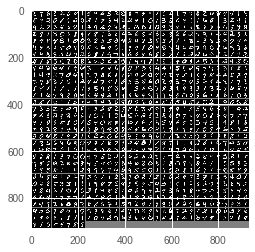

In [7]:
imgs = ds.X[:1000].reshape((-1, 28, 28))
plt.imshow(montage(imgs), cmap='gray')

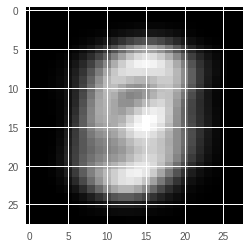

In [8]:
mean_img = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

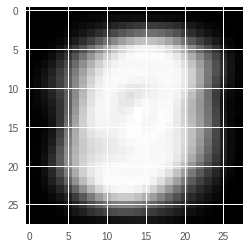

In [9]:
std_img = np.std(ds.X, axis=0)
plt.figure()
plt.imshow(std_img.reshape((28, 28)), cmap='gray')

In [0]:
dimensions = [512, 256, 128, 64]

In [11]:
n_features = ds.X.shape[1]

## [None, n] means that it can have any no of rows m
X = tf.placeholder(tf.float32, [None, n_features])

current_input = X
n_input = n_features


## For Encoder
Ws = []

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        
        W = tf.get_variable(
            name = 'W',
            shape = [n_input, n_output],
            initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws = Ws[::-1]

dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]

print(dimensions)

## Decoder

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        
        W = tf.transpose(Ws[layer_i])
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output

[128, 256, 512, 784]


In [12]:
Y = current_input

cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

print(cost.get_shape())

(?,)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 0.043429777
1 0.03744141
2 0.036008872
3 0.03400051
4 0.03245546
5 0.030389898
6 0.029890427
7 0.029673876
8 0.029586429
9 0.028570276
10 0.02795033
11 0.028760517
12 0.028779762
13 0.027367653
14 0.027454682
15 0.028273677
16 0.027062884
17 0.027776992
18 0.026642151
19 0.026739884
20 0.02778194
21 0.026786245
22 0.026116429
23 0.027417572
24 0.026689386
25 0.02674473
26 0.025256699
27 0.026747216
28 0.026539521
29 0.026520066
30 0.02532551
31 0.026731899
32 0.026847612
33 0.02530954
34 0.026548753
35 0.025981586
36 0.026429405
37 0.024940204
38 0.025761321
39 0.025452843
40 0.025405882
41 0.025094602
42 0.025649583
43 0.025098264
44 0.025351577
45 0.0263564
46 0.025000038
47 0.025414094
48 0.025716359
49 0.02503495
50 0.025140854
51 0.02611863
52 0.02512025
53 0.025060946
54 0.025931768
55 0.025986994
56 0.024946246
57 0.026318133
58 0.024268724
59 0.02494474
60 0.025134254
61 0.024933944
62 0.025657946
63 0.

/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: ignored

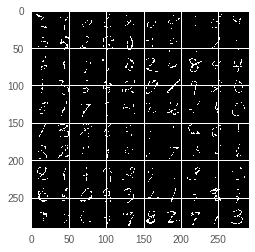

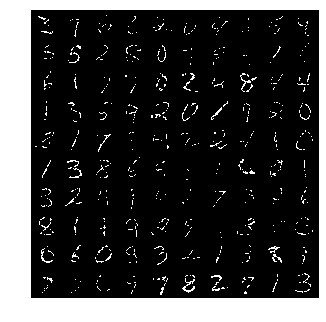

In [13]:
cost = tf.reduce_mean(cost)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

batch_size = 100
n_epochs = 100

examples = ds.X[:100]

imgs = []

fig, ax = plt.subplots(1,1)

for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28,28)), 0, 255)
    
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    
    ax.imshow(img_i, cmap='gray')
    
    fig.canvas.draw()
    
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
    
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [14]:
import IPython.display as ipyd
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [0]:
from tensorflow.python.framework.ops import reset_default_graph

In [0]:
reset_default_graph()

In [17]:
X = tf.placeholder(tf.float32, [None, n_features])

## Reshape placeholder to 4d for convolutional input
## Batch dimension will be filled in place of -1 and
## the shape of the image remains constant.
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

n_filters = [16, 16, 16]
filter_size = [4, 4, 4]

current_input = X_tensor

n_input = 1 # Number of channels in an image

# Will use convolution to find 16 filters/channels of information
Ws = []
shapes = []

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(
            name='W',
            shape=[
                filter_size[layer_i], # height
                filter_size[layer_i], # width
                n_input, # No. of input channels
                n_output # No. of output channels
            ],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        # [1, 2, 2, 1]
        # [batch_dimension, next height, next width, #channel]
        # Take every image. Apply to every other height and width. 
        # Apply to every channel.
        
        h = tf.nn.conv2d(current_input, W, strides=[1, 2, 2, 1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws.reverse()
shapes.reverse()
n_filters.reverse()

n_filters = n_filters[1:] + [1]

print(n_filters, filter_size, shapes)

for layer_i, shape in enumerate(shapes):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        W = Ws[layer_i]
        
        h = tf.nn.conv2d_transpose(
            current_input, W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME'
        )
        
        current_input = tf.nn.relu(h)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


0 0.027004605
1 0.026376119
2 0.026287014
3 0.024056768
4 0.025276626
5 0.025146939
6 0.024078202
7 0.024971707
8 0.024656322
9 0.02392006
10 0.023533497
11 0.02535968
12 0.024145555
13 0.02426873
14 0.024024503
15 0.024398126
16 0.024308957
17 0.023632118
18 0.02401943
19 0.022843227
20 0.024483556
21 0.024305044
22 0.024034595
23 0.02461549
24 0.023577502
25 0.02447543
26 0.023768669
27 0.02390865
28 0.023686027
29 0.023735225
30 0.024214778
31 0.02389024
32 0.02397686
33 0.02439935
34 0.024548087
35 0.02397804
36 0.024875967
37 0.023995273
38 0.024249159
39 0.024392845
40 0.02404036
41 0.024020724
42 0.024310851
43 0.023963483
44 0.02392078
45 0.023997646
46 0.024521248
47 0.024317957
48 0.023707308
49 0.024389207
50 0.023971109
51 0.02326835
52 0.023987852
53 0.024150794
54 0.023987878
55 0.024021912
56 0.023359546
57 0.02400329
58 0.025238743
59 0.023668205
60 0.022958312
61 0.024053836
62 0.023932131
63 0.022700613
64 0.023600496
65 0.024227459
66 0.024000071
67 0.023739986
68 0.

/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: ignored

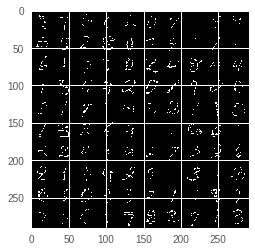

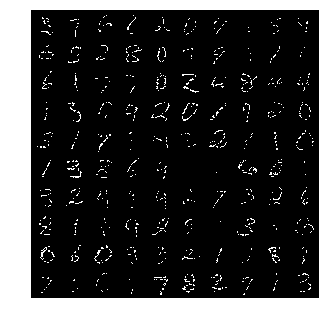

In [18]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()

sess.run(tf.initialize_all_variables())

batch_size = 100
n_epoch = 100

examples = ds.X[:100]

imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [0]:
from libs import datasets

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
7
1
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


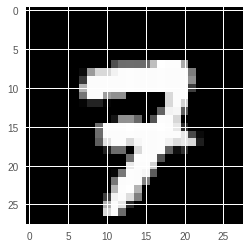

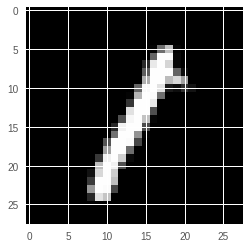

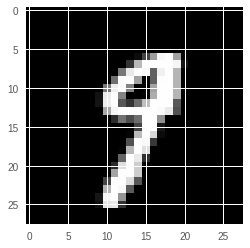

In [20]:
ds = datasets.MNIST(one_hot=False)
print(ds.Y[0])
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')

plt.figure()

print(ds.Y[1])
plt.imshow(np.reshape(ds.X[1], (28, 28)), cmap='gray')

ds = datasets.MNIST(one_hot=True)

plt.figure()

print(ds.Y[0])
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')